Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ **X** ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ **X** ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ **X** ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ **X** ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ **X** ] Commit your notebook to your fork of the GitHub repo.
- [ **X** ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
#Define wrangle function
import numpy as np
def wrangle(X):

  #Copy to prevent silly copy error
  X = X.copy()

  #Treat near-zero lats as 0
  X['latitude'] = X['latitude'].replace(-2e-08,0)

  #Remove columns with zeroes
  cols_with_zeros = ['longitude', 'latitude', 'construction_year', 'gps_height', 'population']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
    X[col+'_MISSING'] = X[col].isnull()

  #Drop duplicate columns
  duplicates = ['quantity_group', 'payment_type']
  X = X.drop(columns=duplicates)

  #Drop unique variables (unusuable variance)
  unus_variance = ['recorded_by', 'id']
  X = X.drop(columns=unus_variance)

  #Convert date to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

  #Extract components from date
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recored'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

  #Engineer new features with dates
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()

  #Return the masterpiece
  return X

train = wrangle(train)
print(train.shape)

(59400, 46)


In [4]:
#Create X feature matrix and y target vector
target = 'status_group'
X_train = train.drop(columns = target)
y_train = train[target]

In [5]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

#Make the pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

# param_distributions = {
#     'simpleimputer__strategy' : ['mean', 'median'],
#     'randomforestclassifier__n_estimators' : randint(50, 500),
#     'randomforestclassifier__max_depth' : [5, 10, 15, 20, None],
#     'randomforestclassifier__max_features' : uniform(0, 1)
# }

# search = RandomizedSearchCV(
#     pipeline,
#     param_distributions = param_distributions,
#     n_iter = 10,
#     cv = 4,
#     scoring = 'accuracy',
#     verbose = 10,
#     return_train_score = True,
#     n_jobs = -1
# )

# search.fit(X_train, y_train)



In [6]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, stratify = train['status_group'], test_size=len(test), random_state=42)



In [7]:
#Create X feature matrix and y target vector
target = 'status_group'
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]

In [8]:
#Make the pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = 'mean'),
    RandomForestClassifier(max_depth = 20, max_features = 0.252, n_estimators= 216,random_state=42)
)


#Fit on train // score on val
pipeline.fit(X_train, y_train)
print('Validation accuracy:', pipeline.score(X_val, y_val))

Validation accuracy: 0.809792450201978


In [9]:
test = wrangle(test)
X_test = test
y_pred = pipeline.predict(X_test)

In [10]:
print(train.shape, val.shape, test.shape)

(45042, 46) (14358, 46) (14358, 45)


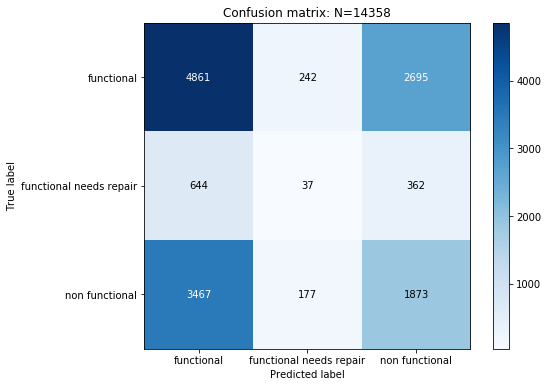

In [13]:
from scikitplot.metrics import plot_confusion_matrix

plot_confusion_matrix(y_val, y_pred,
                     figsize = (8,6),
                      title = f'Confusion matrix: N={len(y_val)}',
                      normalize = False);


## Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.

I really enjoyed this article. I wish I had the python knowledge to make maps like that when I did my biology research instead of the webapp I used. I'm also shocked he's DS3! Wow!